In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')
#plt.rcParams["figure.dpi"] = 600
from sklearn.model_selection import train_test_split

In [2]:
morder = ['MIN', 'OVERFLOW', 'MIXOTROPH', 'EXOENZYME', 'ROS',]
media_order = ['lowN', 'pro99']
mpalette = 'twilight'
sns.color_palette(mpalette, n_colors=5)

[(0.4828677867260272, 0.6304330455306234, 0.761915371498953),
 (0.3668108554010799, 0.26404857724525643, 0.6464799165290824),
 (0.18488035509396164, 0.07942573027972388, 0.21307651648984993),
 (0.5566322903496934, 0.17269677158182117, 0.31423043195101424),
 (0.775907907306857, 0.5355421788246119, 0.42413367909988375)]

In [3]:
gorder = [ 'Strong', 'Sustained', 'Weak', 'Inhibited','Axenic', 'Other']
gpalette = sns.color_palette('Set2', n_colors=4).as_hex() + ['black', 'lightgrey']
sns.color_palette(gpalette)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.0, 0.0, 0.0),
 (0.8274509803921568, 0.8274509803921568, 0.8274509803921568)]

In [4]:
dpath = '../results'
sim_df1 = pd.read_csv(os.path.join(dpath,'monte_het_mse.csv.gz',))
sim_df2 = pd.read_csv(os.path.join(dpath,'monte2_het_mse.csv.gz',))

mse_df = pd.concat([
    sim_df1,
    sim_df2,
])

In [5]:
mse_df.head()

,Sample,full name,Group,RMSE_Bptotal[N],RMSE_Bptotal[C],compare_points,RMSE,run_id
0,10A0,Marinovum 5F3,Weak,16.443312,165.672135,74.0,2724.198605,monte_MIN_80_monte_vpro_3121_MIN_46_lowN_all_M...
1,10B0,Marinovum 5F3,Weak,16.543479,166.722595,74.0,2758.171685,monte_MIN_80_monte_vpro_3121_MIN_46_lowN_all_M...
2,10C0,Marinovum 5F3,Weak,14.668312,151.021301,74.0,2215.227571,monte_MIN_80_monte_vpro_3121_MIN_46_lowN_all_M...
3,11A0,Roseovarius 5C3,Weak,15.026398,153.656861,74.0,2308.909214,monte_MIN_80_monte_vpro_3121_MIN_46_lowN_all_M...
4,11B0,Roseovarius 5C3,Weak,16.098290,162.109943,74.0,2609.692911,monte_MIN_80_monte_vpro_3121_MIN_46_lowN_all_M...


In [6]:
mse_df = mse_df.reset_index(drop=True)

In [7]:
min_mse_df = mse_df.loc[mse_df.groupby('run_id')['RMSE'].idxmin()]

In [31]:
min_mse_df['model'] = min_mse_df.run_id.str.split('_', expand=True)[1]

In [59]:
min_mse_df.run_id.str.replace('.*vpro','', regex=True)
split('_', expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11
1688943,monte2,ROS,100,monte,vpro,3135,ROS,92,lowN,all,ROS,h-8660846992299669535
1505252,monte2,ROS,100,monte,vpro,316,ROS,49,lowN,all,ROS,h-8660846992299669535
1614421,monte2,ROS,100,monte,vpro,3223,ROS,12,lowN,all,ROS,h-8660846992299669535
1519332,monte2,ROS,100,monte,vpro,324,ROS,50,lowN,all,ROS,h-8660846992299669535
1567872,monte2,ROS,100,monte,vpro,324,ROS,71,lowN,all,ROS,h-8660846992299669535
...,...,...,...,...,...,...,...,...,...,...,...,...
1271283,monte,ROS,9,monte,vpro,4901,ROS,11,lowN,all,ROS,h-8660846992299669535
660780,monte,ROS,9,monte,vpro,4902,ROS,35,lowN,all,ROS,h-8660846992299669535
640632,monte,ROS,9,monte,vpro,4915,ROS,60,lowN,all,ROS,h-8660846992299669535
198342,monte,ROS,9,monte,vpro,4917,ROS,51,lowN,all,ROS,h-8660846992299669535


In [8]:
del mse_df

In [32]:
df = min_mse_df

In [9]:
min_mse_df['run_id'].value_counts()

monte2_ROS_100_monte_vpro_3135_ROS_92_lowN_all_ROS_h-8660846992299669535                  1
monte_MIXOTROPH_93_monte_vpro_3233_MIXOTROPH_59_lowN_all_MIXOTROPH_h674153805448169520    1
monte_MIXOTROPH_92_monte_vpro_4976_MIXOTROPH_65_lowN_all_MIXOTROPH_h674153805448169520    1
monte_MIXOTROPH_92_monte_vpro_4995_MIXOTROPH_17_lowN_all_MIXOTROPH_h674153805448169520    1
monte_MIXOTROPH_93_monte_vpro_314_MIXOTROPH_81_lowN_all_MIXOTROPH_h674153805448169520     1
                                                                                         ..
monte_MIN_100_monte_vpro_481_MIN_96_lowN_all_MIN_h-1541717058758371284                    1
monte_MIN_100_monte_vpro_4830_MIN_40_lowN_all_MIN_h-1541717058758371284                   1
monte_MIN_100_monte_vpro_4889_MIN_74_lowN_all_MIN_h-1541717058758371284                   1
monte_MIN_100_monte_vpro_4934_MIN_52_lowN_all_MIN_h-1541717058758371284                   1
monte_ROS_9_monte_vpro_4933_ROS_97_lowN_all_ROS_h-8660846992299669535           

In [12]:
#df_predicted_classes.shape, 
min_mse_df.shape, df.shape

((57326, 8), (57326, 8))

In [13]:
df.head()

,Sample,full name,Group,RMSE_Bptotal[N],RMSE_Bptotal[C],compare_points,RMSE,run_id
1688943,11A0,Roseovarius 5C3,Weak,7.632608,77.660667,74.0,592.753414,monte2_ROS_100_monte_vpro_3135_ROS_92_lowN_all...
1505252,10C0,Marinovum 5F3,Weak,1.173466,20.785016,74.0,24.390504,monte2_ROS_100_monte_vpro_316_ROS_49_lowN_all_...
1614421,10B0,Marinovum 5F3,Weak,2.466296,27.539105,74.0,67.919595,monte2_ROS_100_monte_vpro_3223_ROS_12_lowN_all...
1519332,3A0,Marinobacter adhaerens HP15,Inhibited,0.000000,8.372289,74.0,0.000000,monte2_ROS_100_monte_vpro_324_ROS_50_lowN_all_...
1567872,3A0,Marinobacter adhaerens HP15,Inhibited,0.000000,8.442627,74.0,0.000000,monte2_ROS_100_monte_vpro_324_ROS_71_lowN_all_...


In [14]:
df.shape

(57326, 8)

In [15]:
df[['Group']].value_counts().reset_index()

,Group,0
0,Weak,46819
1,Inhibited,9549
2,Sustained,812
3,Axenic,116
4,Strong,30


In [33]:
df[['Group','model']].value_counts().reset_index()

,Group,model,0
0,Weak,MIN,9883
1,Weak,EXOENZYME,9740
2,Weak,MIXOTROPH,9615
3,Weak,OVERFLOW,9472
4,Inhibited,ROS,9185
5,Weak,ROS,8109
6,Sustained,ROS,489
7,Sustained,MIXOTROPH,164
8,Sustained,EXOENZYME,151
9,Inhibited,MIN,115


In [16]:
df['full name'].value_counts()

E. coli                           30687
Marinovum 5F3                     13625
Marinobacter adhaerens HP15        8203
Roseovarius 5C3                    2507
Phaeobacter gallaeciensis          1346
Ruegeria pomeroyi                   684
Sulfitobacter pseudonitzschiae      128
Axenic                              116
Pseudoalteromonas haloplanktis       30
Name: full name, dtype: int64

In [17]:
df['RMSE'].describe()

count    57326.000000
mean      1110.170580
std        796.838553
min          0.000000
25%        268.316665
50%       1196.865280
75%       1756.036784
max       4453.900263
Name: RMSE, dtype: float64

In [18]:
df['RMSE_clip'] = df.RMSE.clip(upper=1000)

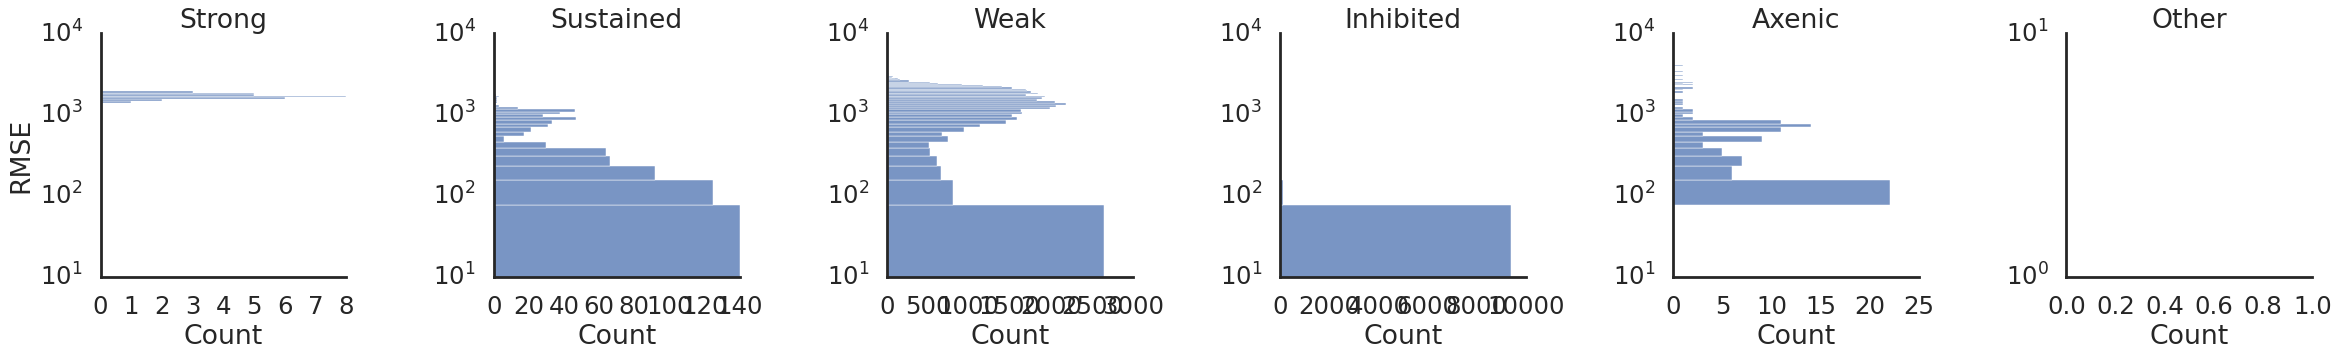

In [26]:
g = sns.displot(
    data=df,
    #col='y_pred', 
    col='Group', col_order=gorder,
    y='RMSE',
    facet_kws=dict(sharex=False, sharey=False,margin_titles=True),
    #row='model',

)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(yscale='log')

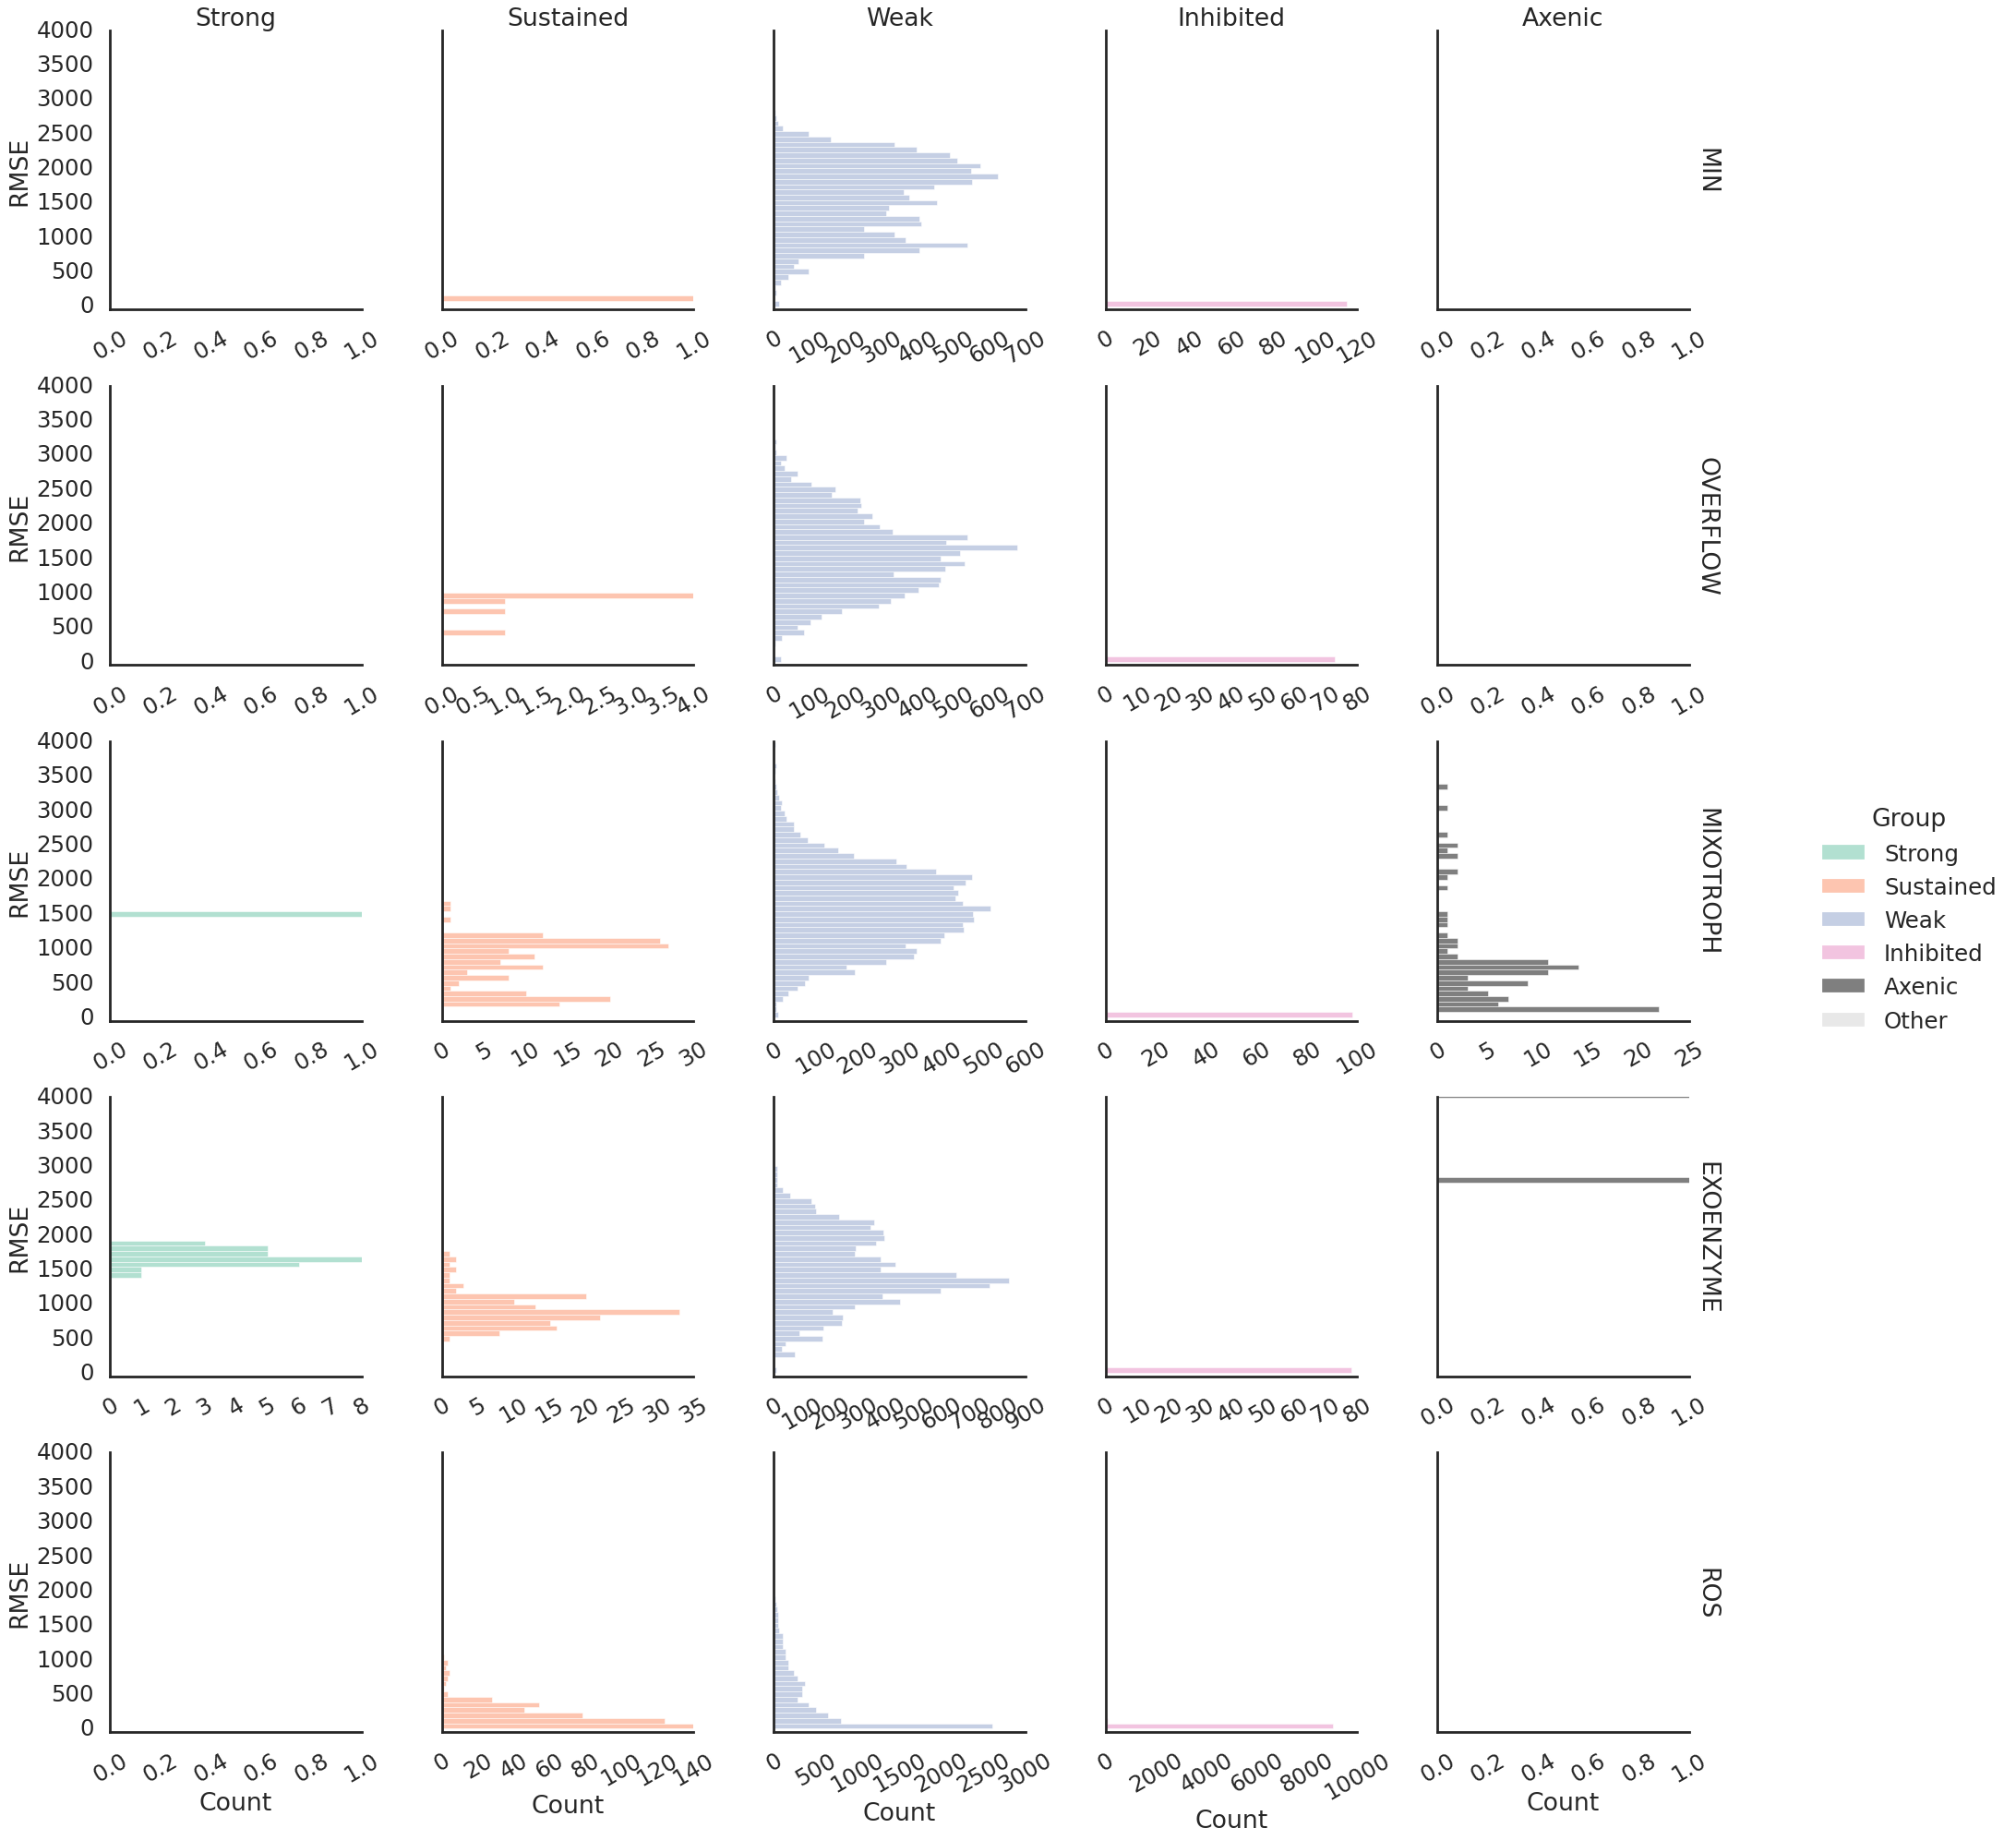

In [58]:
g = sns.displot(
    data=df,
    row='model', row_order=morder, 
    col='Group', col_order=gorder[:-1],
    #palette=mpalette, hue='model', hue_order=morder,
    palette=gpalette, hue='Group', hue_order=gorder,
    
    y='RMSE', #log_scale=True,
    facet_kws=dict(sharex=False, margin_titles=True), #sharey=False,
    #row='model',
    

)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(ylim=(-50,4000))
g.set_xticklabels(rotation=30)

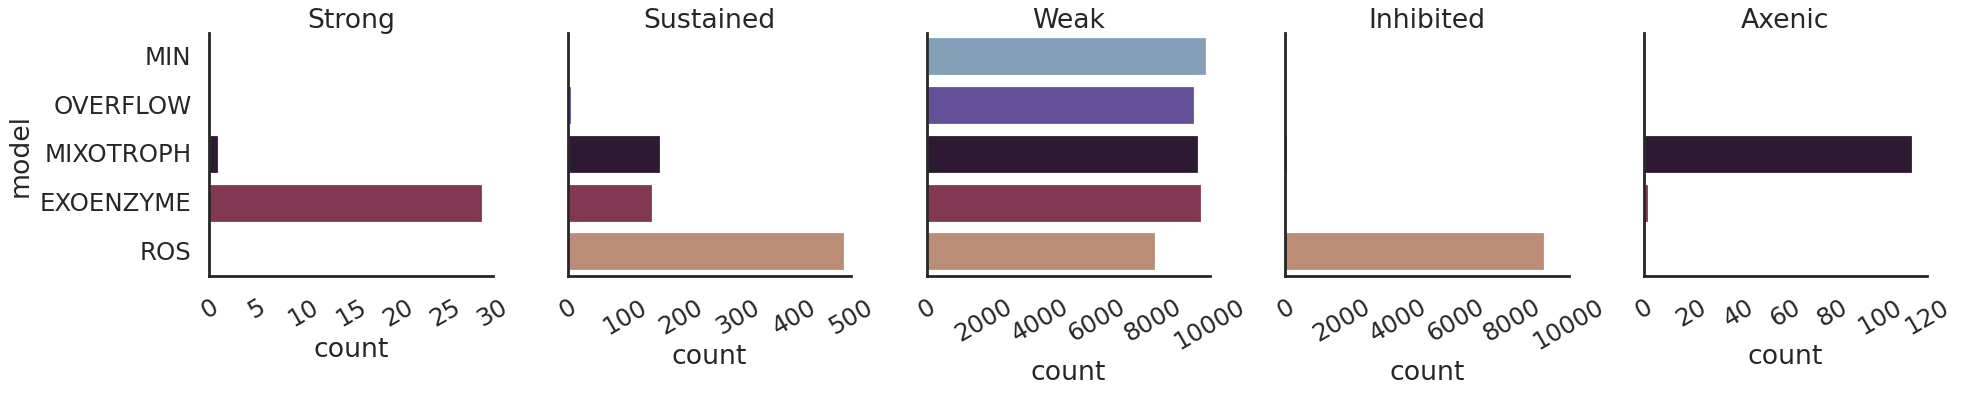

In [47]:
g = sns.catplot(
    data=df,
    y='model', order=morder, 
    col='Group', col_order=gorder[:-1],
    palette=mpalette, hue='model', hue_order=morder, dodge=False,
    kind='count',
    facet_kws=dict(sharex=False, margin_titles=True),
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
#g.set(yscale='log')
g.set_xticklabels(rotation=30)

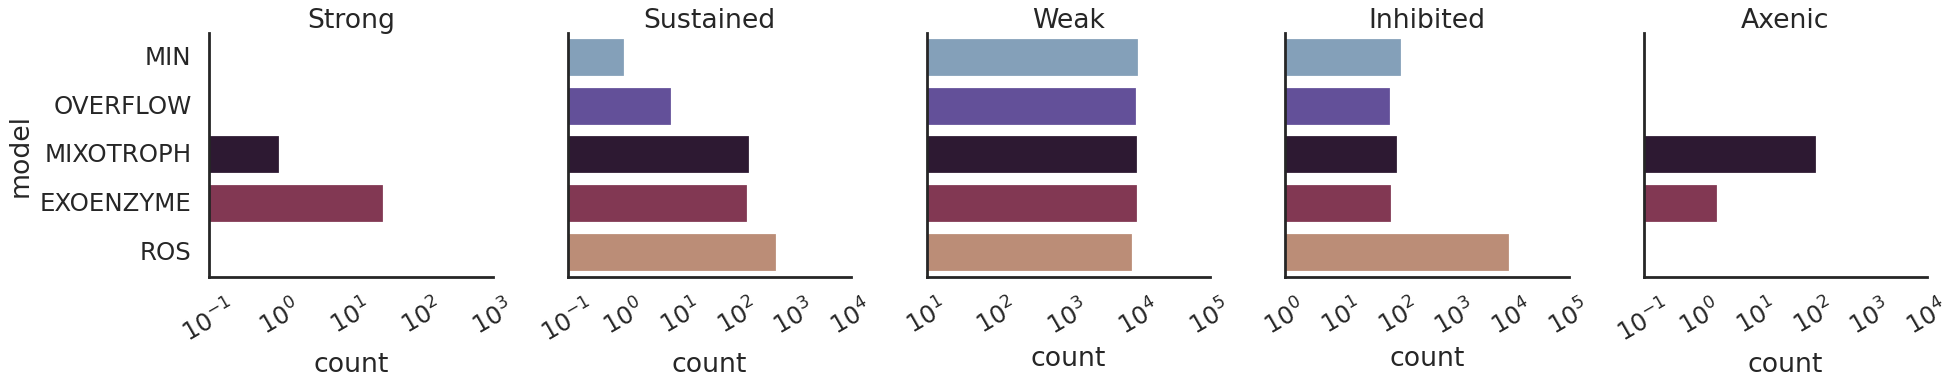

In [51]:
g = sns.catplot(
    data=df,
    y='model', order=morder, 
    col='Group', col_order=gorder[:-1],
    palette=mpalette, hue='model', hue_order=morder, dodge=False,
    kind='count',
    facet_kws=dict(sharex=False, margin_titles=True),
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(xscale='log')
g.set_xticklabels(rotation=30)

In [53]:
df.pivot_table(index='model', columns='Group', values='run_id', aggfunc='count', fill_value=0)

Group,Axenic,Inhibited,Strong,Sustained,Weak
model,,,,,
EXOENZYME,2,78,29,151,9740
MIN,0,115,0,1,9883
MIXOTROPH,114,98,1,164,9615
OVERFLOW,0,73,0,7,9472
ROS,0,9185,0,489,8109


In [ ]:
df[['Group','model']].value_counts().reset_index()

In [14]:
df.groupby(['Group', 'y_pred']).size()

Group      y_pred   
Axenic     Axenic       13430
           Other        45978
           Strong          10
           Sustained      889
           Weak          1790
Inhibited  Inhibited      794
           Other          390
Strong     Axenic          14
           Other          382
           Strong         116
           Sustained        8
Sustained  Axenic         313
           Other         1365
           Sustained       47
           Weak           171
Weak       Axenic         298
           Other        17850
           Sustained      660
           Weak         37835
dtype: int64

In [18]:
df.RMSE.describe()

count    122340.000000
mean        472.572764
std        4392.891885
min           0.000000
25%         129.856143
50%         288.072704
75%         553.098736
max      474670.929463
Name: RMSE, dtype: float64

In [27]:
df['Group'].value_counts(), df['y_pred'].value_counts()


(Axenic       62097
 Weak         56643
 Sustained     1896
 Inhibited     1184
 Strong         520
 Name: Group, dtype: int64,
 Other        66002
 Weak         39848
 Axenic       14076
 Sustained     1611
 Inhibited      797
 Strong         126
 Name: y_pred, dtype: int64)

In [31]:
df.run_id.str.split('_', expand=True)[0].value_counts()

monte4    42678
monte     42431
monte3    37351
Name: 0, dtype: int64

In [32]:
df_predicted_classes

,run_id,y_pred,max_prob,idx,media,which,model,hash
0,monte3_EXOENZYME_100_monte_shgo3_sobol_151_EXO...,Axenic,0.797270,monte3_EXOENZYME_100_monte_shgo3_sobol_151_EXO...,lowN,all,EXOENZYME,h1628948357718170805
1,monte3_EXOENZYME_100_monte_shgo3_sobol_163_EXO...,Other,0.986509,monte3_EXOENZYME_100_monte_shgo3_sobol_163_EXO...,lowN,all,EXOENZYME,h1628948357718170805
2,monte3_EXOENZYME_100_monte_shgo3_sobol_163_EXO...,Other,0.868453,monte3_EXOENZYME_100_monte_shgo3_sobol_163_EXO...,lowN,all,EXOENZYME,h1628948357718170805
3,monte3_EXOENZYME_100_monte_shgo3_sobol_199_EXO...,Other,0.863919,monte3_EXOENZYME_100_monte_shgo3_sobol_199_EXO...,lowN,all,EXOENZYME,h1628948357718170805
4,monte3_EXOENZYME_100_monte_shgo3_sobol_199_EXO...,Other,0.787651,monte3_EXOENZYME_100_monte_shgo3_sobol_199_EXO...,lowN,all,EXOENZYME,h1628948357718170805
...,...,...,...,...,...,...,...,...
122455,monte_ROS_9_monte_vpro_4386_ROS_1_lowN_all_ROS...,Other,0.552056,monte_ROS_9_monte_vpro_4386_ROS_1,lowN,all,ROS,h5853139000967720769
122456,monte_ROS_9_monte_vpro_4386_ROS_3_lowN_all_ROS...,Other,0.814095,monte_ROS_9_monte_vpro_4386_ROS_3,lowN,all,ROS,h5853139000967720769
122457,monte_ROS_9_monte_vpro_4511_ROS_0_lowN_all_ROS...,Axenic,0.707792,monte_ROS_9_monte_vpro_4511_ROS_0,lowN,all,ROS,h5853139000967720769
122458,monte_ROS_9_monte_vpro_4901_ROS_5_lowN_all_ROS...,Weak,0.633817,monte_ROS_9_monte_vpro_4901_ROS_5,lowN,all,ROS,h5853139000967720769


In [40]:
df_predicted_classes['VPRO'] = df_predicted_classes.run_id.str.replace(
    r'.*_monte.?_','', regex=True).str.replace(
    r'_\d*_lowN_all.*', '', regex=True)

In [41]:
df_predicted_classes.groupby('model').VPRO.nunique()

model
EXOENZYME    227
MIN          223
MIXOTROPH    247
OVERFLOW     253
ROS          238
Name: VPRO, dtype: int64

In [63]:
number_of_predictions = df_predicted_classes.pivot_table(index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0).reindex(columns=gorder).sort_values(by=gorder)

In [75]:
df_predicted_classes.pivot_table(index='model', columns='y_pred', values='VPRO', aggfunc='count', fill_value=0).reindex(columns=gorder, index=morder)

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
model,,,,,,
MIN,0,0,10849,0,2713,16372
OVERFLOW,62,554,7806,696,3935,6168
MIXOTROPH,0,250,7528,100,3444,16407
EXOENZYME,7,772,9441,0,1789,17885
ROS,57,35,4224,1,2195,9170


In [69]:
plt.showow()

In [105]:
df_predicted_classes.groupby('model')['VPRO'].nunique()

model
EXOENZYME    227
MIN          223
MIXOTROPH    247
OVERFLOW     253
ROS          238
Name: VPRO, dtype: int64

In [104]:
df_predicted_classes.pivot_table(index='model', columns='y_pred', values='VPRO', aggfunc='nunique', fill_value=0).reindex(columns=gorder, index=morder)

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
model,,,,,,
MIN,0,0,204,0,41,169
OVERFLOW,31,102,222,198,120,243
MIXOTROPH,0,39,153,6,111,229
EXOENZYME,1,51,160,0,62,217
ROS,3,2,170,1,54,176


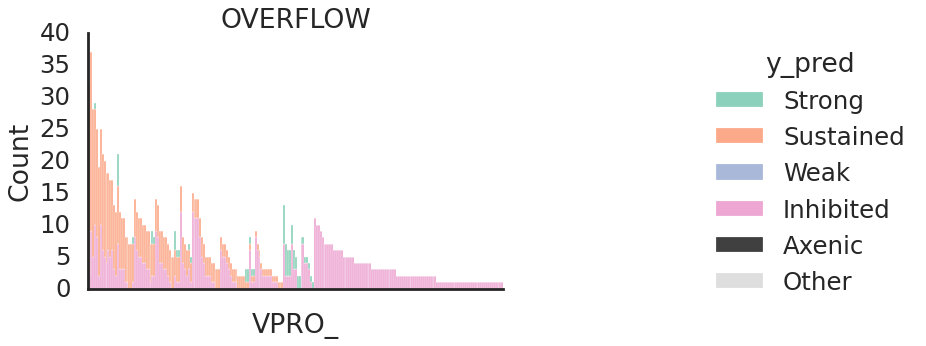

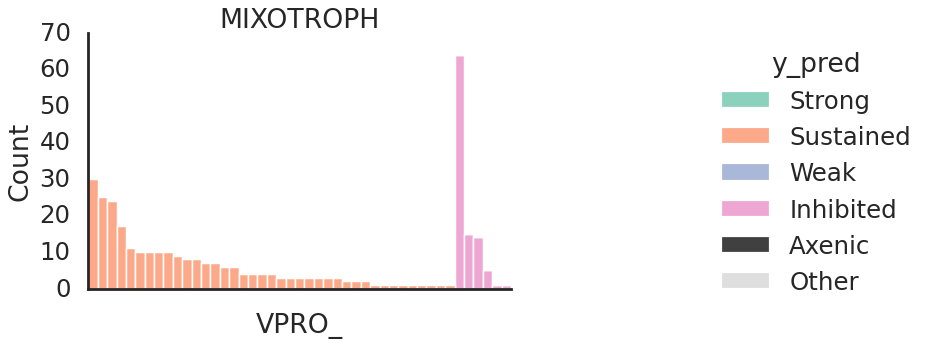

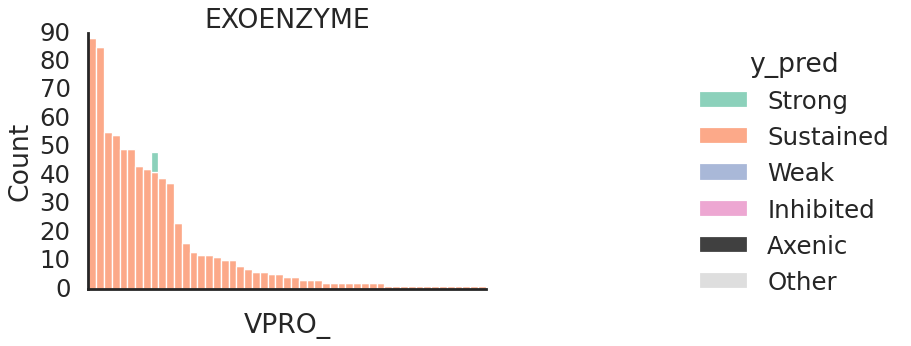

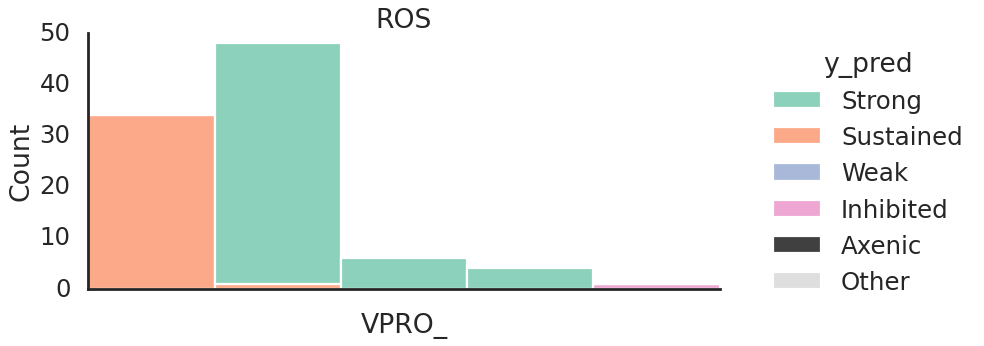

In [103]:
for m in morder:
    t = df_predicted_classes.loc[
        df_predicted_classes.model.isin([m]) & 
        df_predicted_classes.y_pred.isin([ 'Sustained','Strong', 'Inhibited', ])
    ].copy()
    if t.shape[0]>0:
        tnumdf = t.pivot_table(
            index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
        ).reindex(columns=[ 'Inhibited','Strong','Sustained',  ])
        #tnumdf['total'] = tnumdf.sum(axis=1)        
        tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
        t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))
        g = sns.displot(
            data=t,
            hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
            hue_order=gorder, palette=gpalette,
            aspect=2,
                   )
        g.set(xticklabels=[])
        g.set_titles(col_template='{col_name}', row_template='{row_name}')
        plt.title(m)


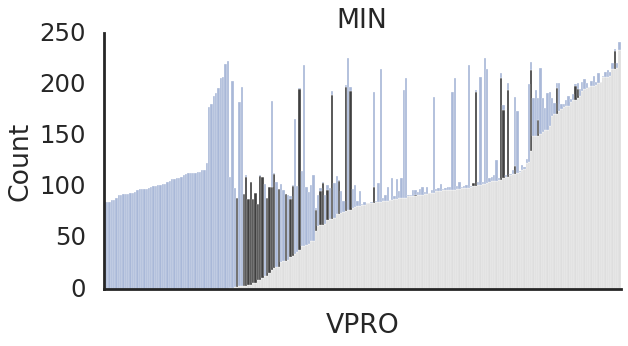

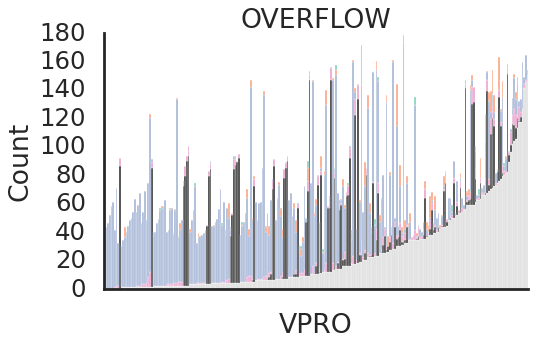

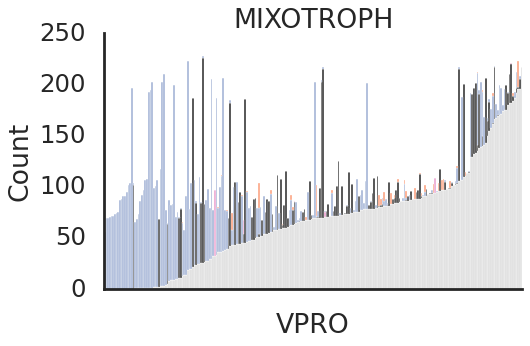

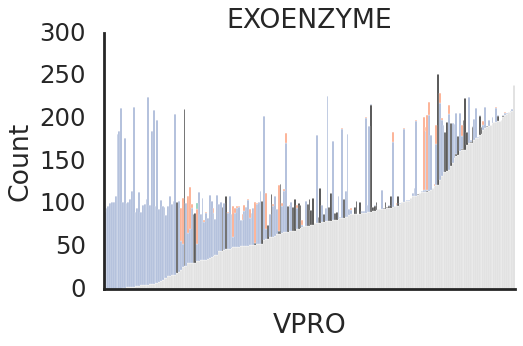

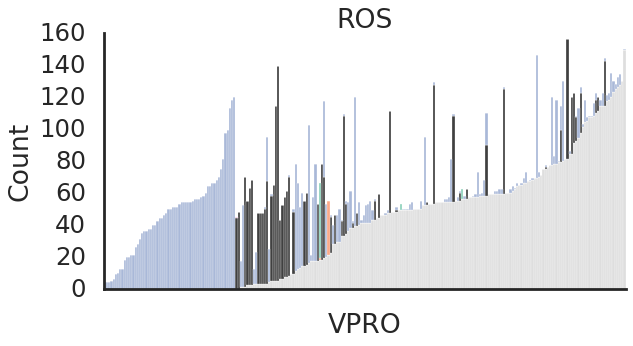

In [107]:
for m in morder:
    t = df_predicted_classes.loc[
        df_predicted_classes.model.isin([m]) #& 
        #df_predicted_classes.y_pred.isin([ 'Sustained','Strong', 'Inhibited', ])
    ].copy()
    if t.shape[0]>0:
        tnumdf = t.pivot_table(
            index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
        ).reindex(columns=gorder)
        #tnumdf['total'] = tnumdf.sum(axis=1)        
        tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
        t['VPRO_'] = pd.Categorical(t['VPRO'], tnumdf.index)
        g = sns.displot(
            data=t,
            hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
            hue_order=gorder, palette=gpalette,
            aspect=2,
            legend=False,
                   )
        
        g.set(xticklabels=[], xlabel='VPRO')
        g.set_titles(col_template='{col_name}', row_template='{row_name}')
        plt.title(m)
